In [1]:
import glob
import os
#import triangle
import time
import numpy as np
from astropy.io import fits
from sklearn.decomposition import PCA
from sklearn import svm
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from scipy import convolve
from scipy import optimize as opt
import scipy.optimize as op
from numpy import ones,vstack
from numpy.linalg import lstsq
from astroquery.vizier import Vizier
import urllib2
from astroquery.sdss import SDSS

import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

//anaconda/envs/py27/lib/python2.7/site-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [2]:
catalog_list = Vizier.find_catalogs('New white dwarf SDSS DR12')

print({k:v.description for k,v in catalog_list.items()})

{u'J/MNRAS/455/3413': u'New white dwarf and subdwarf stars in SDSS DR12 (Kepler+, 2016)'}


In [3]:
Vizier.ROW_LIMIT = -1
catalogs = Vizier.get_catalogs(catalog_list.keys())

In [4]:
# HDU_list = fits.open("spectra/spec-0387-51791-0005.fits")


SN_array = np.array([])
ra_array = []
dec_array = []

#HARD CODES FILE FOR TEST
directory = '/Users/MichaelFoley/WDSpectralFitting/notebooks/data/'
# Kleinman DA Spectra
#for filename in glob.glob(directory+"*.fits"):
#filename = directory + "spec-1853-53566-0422.fits"
filename = directory + "spec-7454-56751-0026.fits"

data = fits.getdata(filename, 1)
temp = fits.getdata(filename, 2)
SN_array = np.append(SN_array, temp["SN_MEDIAN_ALL"])

all_flux = data['flux']
all_lambda = 10 ** data['loglam']
print all_flux
print all_lambda

# # Load Kleinman spectra
# datafile = os.path.abspath("./kleinman_masses.dat")
# names = ["RA","Dec","M_wd","M_wd_err"]
# kleinman_masses = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)
    

# # ELM Spectra
# for filename in glob.glob("spectra_ELM/*.fits"):
#     data = fits.getdata(filename, 1)
    
#     temp = fits.getdata(filename, 2)
#     SN_array = np.append(SN_array, temp["SN_MEDIAN_ALL"])
    
#     all_flux.append(data['flux'])
#     all_lambda.append(10 ** data['loglam'])
#     ra_array = np.append(ra_array, temp['PLUG_RA'])
#     dec_array = np.append(dec_array, temp['PLUG_DEC'])

    

#    break
    

IOError: [Errno 2] No such file or directory: '/Users/MichaelFoley/WDSpectralFitting/notebooks/data/spec-7454-56751-0026.fits'

In [ ]:
# Check a spectrum to make sure everything looks good
plt.plot(all_lambda,all_flux)
plt.show()

#print ra_array[3], dec_array[3]



In [ ]:
# Let's find the highest S/N spectrum

index_best = np.argmax(SN_array)

print index_best

### Now let's see if we can fit the spectrum to a model with several components:


1. T$_{\rm eff}$
2. Shift in $x$ to get the middle of the line profiles
3. Scale parameter for each Balmer line
4. Multiplicative factor for each Balmer line
5. Overall scale factor to account for brightness of overall spectrum

There are therefore 15 parameters overall. This is because we want to fit 6 hydrogen Balmer lines (H$\alpha$ to H8), and each line has two parameters.

### Let's create our model

In [7]:
# Our model has a temperature effect, then absorption features on top of the model


# Constants
h_planck = 4.136e-15 # in eV*s 
c_light = 2.998e10   # in cgs
k_boltz = 8.617e-5   # in eV/K


# Balmer line centers (in cgs):
lambda_balmer = np.array([6563, 4861, 4341, 4102, 3970, 3889])
window_dict = {}

In [8]:
# Lorentz distribution:
def lorentz(C_coeff, x_center, gamma, x):
    return -C_coeff / (np.pi * gamma * (1.0 + ((x-x_center)/gamma)**2))

#We must define our probability function in order to use emcee
def like(p, x, y):
    C_coeff, x_center, gamma = p
    model = lorentz(C_coeff, x_center, gamma, x)
    sigma = (model - y)**2
    return np.sum(sigma)

def my_line(points, x_vec):
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]
    return m*x_vec + c

def FWHM(height,norm):
    gam = 1/(np.pi*np.abs(height))
    return gam*norm

In [13]:
nll = lambda *args: -like(*args)

def spectrum_fit(lambda_balmer,all_lambda,all_flux,num):
    line = lambda_balmer[num]
    window = np.where(np.logical_and(all_lambda>= (line - 30), all_lambda<= (line + 30)))[0]
    
    #Get an educated guess for C_true
    thirds = len(all_flux[window])/3
    left_max = np.max(all_flux[window][:thirds])
    right_max = np.max(all_flux[window][-thirds:])
    left_point = all_lambda[window][:thirds][np.argmax(all_flux[window][:thirds])]
    right_point = all_lambda[window][2*thirds + np.argmax(all_flux[window][-thirds:])]

    points = [(left_point,left_max),(right_point,right_max)]
    vert_fix = my_line(points,all_lambda[window])
    int_y = all_flux[window]-vert_fix
    result = np.trapz(int_y)
    
    left_mean = np.mean(all_flux[window][:thirds])
    right_mean = np.mean(all_flux[window][-thirds:])
    left_lambda = np.mean(all_lambda[window][:thirds])
    right_lambda = np.mean(all_lambda[window][-thirds:])

    points = [(left_lambda,left_mean),(right_lambda,right_mean)]
    vert_shift = my_line(points,all_lambda[window])
    
    #Define initial guesses
    C_true = result*-1
    x_true = (all_lambda[window][0] + all_lambda[window[-1]])/2
    gamma_true = FWHM(np.min(all_flux[window]-vert_shift),C_true)
    print gamma_true
    
    result = op.minimize(nll, [C_true, x_true, gamma_true], args=(all_lambda[window],all_flux[window]))
    C_coeff_ls, x_center_ls, gamma_ls = result["x"]
    
    return C_coeff_ls, x_center_ls, gamma_ls, window, vert_fix, vert_shift


In [19]:
#Main loop
with open('SDSS_lorentz_params.txt', 'w') as lorentz_params:
    lorentz_params.write('Plate C1 X1 G1 C2 X2 G2 C3 X3 G3 C4 X4 G4 C5 X5 G5 C6 X6 G6 \n')
# lorentz_params = open('SDSS_lorentz_params.txt', 'w')
# lorentz_params.write('Plate C1 X1 G1 C2 X2 G2 C3 X3 G3 C4 X4 G4 C5 X5 G5 C6 X6 G6 \n')

C_coeff_ls = np.zeros(6)
x_center_ls = np.zeros(6)
gamma_ls = np.zeros(6)
total = 1
for i in range(len(catalogs[0]['SpType'])):
    if 'DA' in catalogs[0]['SpType'][i]:
        print 'Got one'
        plate = catalogs[0]['PMF'][i]
        
        #Gets data from file
        filename = directory + "spec-"+str(plate)+".fits"
        data = fits.getdata(filename, 1)
        
        all_flux = data['flux']
        all_lambda = 10 ** data['loglam']
        
        with open('SDSS_lorentz_params.txt', 'a') as lorentz_params:
            lorentz_params.write(str(total) + ' ' + str(plate))
        total = total + 1
        print total
        for ind,line in enumerate(lambda_balmer):
            #Make the windows for lorentzian fitting
            
            window = np.where(np.logical_and(all_lambda>= (line - 30), all_lambda<= (line + 30)))[0]

            #Get an educated guess for C_true
            if not all_flux[window].size:
                C_coeff_ls[ind] = 0.0
                x_center_ls[ind] = 0.0
                gamma_ls[ind] = 0.0
                
                with open('SDSS_lorentz_params.txt', 'a') as lorentz_params:
                    lorentz_params.write(' ' + str(C_coeff_ls[ind]) + ' ' + str(x_center_ls[ind]) + ' ' + str(-gamma_ls[ind]))
                continue
            
            thirds = len(all_flux[window])/3
            left_max = np.max(all_flux[window][:thirds])
            right_max = np.max(all_flux[window][-thirds:])
            left_point = all_lambda[window][:thirds][np.argmax(all_flux[window][:thirds])]
            right_point = all_lambda[window][2*thirds + np.argmax(all_flux[window][-thirds:])]

            points = [(left_point,left_max),(right_point,right_max)]
            vert_fix = my_line(points,all_lambda[window])
            int_y = all_flux[window]-vert_fix
            result = np.trapz(int_y)

            left_mean = np.mean(all_flux[window][:thirds])
            right_mean = np.mean(all_flux[window][-thirds:])
            left_lambda = np.mean(all_lambda[window][:thirds])
            right_lambda = np.mean(all_lambda[window][-thirds:])

            points = [(left_lambda,left_mean),(right_lambda,right_mean)]
            vert_shift = my_line(points,all_lambda[window])

            #Define initial guesses
            C_true = result*-1
            x_true = (all_lambda[window][0] + all_lambda[window[-1]])/2
            gamma_true = FWHM(np.min(all_flux[window]-vert_shift),C_true)
#             print gamma_true

            result = op.minimize(nll, [C_true, x_true, gamma_true], args=(all_lambda[window],all_flux[window]))
            C_coeff_ls[ind], x_center_ls[ind], gamma_ls[ind] = result["x"]
            
            with open('SDSS_lorentz_params.txt', 'a') as lorentz_params:
                lorentz_params.write(' ' + str(C_coeff_ls[ind]) + ' ' + str(x_center_ls[ind]) + ' ' + str(gamma_ls[ind]))
#             print str(C_coeff_ls[ind])
            
#             check_y = lorentz(C_coeff_ls[ind], x_center_ls[ind], gamma_ls[ind], all_lambda[window])
#             plt.plot(all_lambda[window],check_y+1.1*vert_shift)
#             plt.plot(all_lambda[window],vert_fix)
#             plt.plot(all_lambda[window],all_flux[window])
#             plt.savefig('%s-%d.png' %(plate,ind))
#             plt.clf()
        with open('SDSS_lorentz_params.txt', 'a') as lorentz_params:
            lorentz_params.write('\n')

Got one
2
Got one
3
Got one
4
Got one
5
Got one
6
Got one
7
Got one
8
Got one
9
Got one
10
Got one
11
Got one
12
Got one
13
Got one
14
Got one
15
Got one
16
Got one
17
Got one
18
Got one
19
Got one
20
Got one
21
Got one
22
Got one
23
Got one
24
Got one
25
Got one
26
Got one
27
Got one
28
Got one
29
Got one
30
Got one
31
Got one
32
Got one
33
Got one
34
Got one
35
Got one
36
Got one
37
Got one
38
Got one
39
Got one
40
Got one
41
Got one
42
Got one
43
Got one
44
Got one
45
Got one
46
Got one
47
Got one
48
Got one
49
Got one
50
Got one
51
Got one
52
Got one
53
Got one
54
Got one
55
Got one
56
Got one
57
Got one
58
Got one
59
Got one
60
Got one
61
Got one
62
Got one
63
Got one
64
Got one
65
Got one
66
Got one
67
Got one
68
Got one
69
Got one
70
Got one
71
Got one
72
Got one
73
Got one
74
Got one
75
Got one
76
Got one
77
Got one
78
Got one
79
Got one
80
Got one
81
Got one
82
Got one
83
Got one
84
Got one
85
Got one
86
Got one
87
Got one
88
Got one
89
Got one
90
Got one
91
Got one
92
Got one

IOError: [Errno 2] No such file or directory: '/Users/MichaelFoley/WDSpectralFitting/notebooks/data/spec-6686-56412-0868.fits'

Please select a balmer line to fit: 4
-13.5103811477


/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


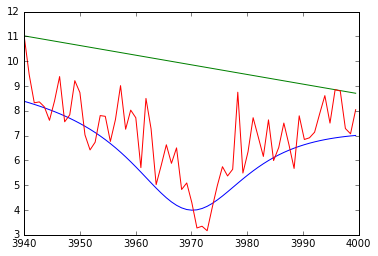

In [108]:
num = raw_input("Please select a balmer line to fit: ")
C_coeff_ls, x_center_ls, gamma_ls, window, vert_fix, vert_shift = spectrum_fit(lambda_balmer,all_lambda,all_flux,num)
check_y = lorentz(C_coeff_ls, x_center_ls, gamma_ls, all_lambda[window])

plt.plot(all_lambda[window],-check_y+1.1*vert_shift)
plt.plot(all_lambda[window],vert_fix)

plt.plot(all_lambda[window],all_flux[window])